<a href="https://colab.research.google.com/github/GiovaniValdrighi/school_eval_ethical/blob/main/notebooks/modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

## Data preparation

In [2]:
df = pd.read_csv("/content/drive/MyDrive/courses/ai_ethics/school_eval/data/microdados_saeb_2019/clean_schools_v2.csv")
df.head()

,ID_REGIAO,ID_UF,ID_MUNICIPIO,ID_AREA,ID_LOCALIZACAO,PC_FORMACAO_DOCENTE_FINAL,NIVEL_SOCIO_ECONOMICO,NU_MATRICULADOS_CENSO_9EF,NU_PRESENTES_9EF,TAXA_PARTICIPACAO_9EF,...,TX_RESP_Q245,TX_RESP_Q246,TX_RESP_Q247,TX_RESP_Q248,TX_RESP_Q249,TX_RESP_Q250,TX_RESP_Q251,TX_RESP_Q252,TX_RESP_Q253,MEDIA
0,1.0,11.0,6311030.0,2.0,1.0,48.9,Nível IV,14.0,14.0,1.000000,...,invalido,invalido,invalido,invalido,invalido,invalido,invalido,C,C,242.350
1,1.0,11.0,6311030.0,2.0,1.0,55.6,Nível III,16.0,14.0,0.875000,...,invalido,invalido,invalido,invalido,invalido,invalido,invalido,D,D,270.780
2,1.0,11.0,6311030.0,2.0,2.0,45.5,Nível IV,12.0,10.0,0.833333,...,B,B,B,B,B,A,B,D,D,245.215
3,1.0,11.0,6311030.0,2.0,1.0,72.9,Nível IV,209.0,195.0,0.933014,...,invalido,invalido,invalido,invalido,invalido,invalido,invalido,D,E,270.980
4,1.0,11.0,6311030.0,2.0,1.0,36.5,Nível IV,12.0,10.0,0.833333,...,invalido,invalido,invalido,invalido,invalido,invalido,invalido,D,D,240.935


### Converting columns values

In [3]:
n_unique = df.nunique()
only_one_value = n_unique[n_unique == 1].index.values.tolist()
too_many_values = n_unique[n_unique > 30].index.values.tolist()
only_one_value + too_many_values

['TX_RESP_Q037',
 'ID_MUNICIPIO',
 'PC_FORMACAO_DOCENTE_FINAL',
 'NU_MATRICULADOS_CENSO_9EF',
 'NU_PRESENTES_9EF',
 'TAXA_PARTICIPACAO_9EF',
 'TX_RESP_Q010',
 'TX_RESP_Q017',
 'TX_RESP_Q021',
 'TX_RESP_Q067',
 'MEDIA']

In [4]:
# drop column with unique value or too many values
df = df.drop(columns = ["TX_RESP_Q037", "ID_MUNICIPIO"])

Converting column coded values to named values.

In [5]:
id_regiao = {1 : "norte", 2: "nordeste", 3:"sudeste", 4:"sul", 5:"centro-oeste"}
id_uf = {11: 'RO',
 12: 'AC',
 13: 'AM',
 14: 'RR',
 15: 'PA',
 16: 'AP',
 17: 'TO',
 21: 'MA',
 22: 'PI',
 23: 'CE',
 24: 'RN',
 25: 'PB',
 26: 'PE',
 27: 'AL',
 28: 'SE',
 29: 'BA',
 31: 'MG',
 32: 'ES',
 33: 'RJ',
 35: 'SP',
 41: 'PR',
 42: 'SC',
 43: 'RS',
 50: 'MS',
 51: 'MT',
 52: 'GO',
 53: 'DF'}
id_area = {1: "capital", 2:"interior"}
id_localizacao = {1 : "urbana", 2:"rural"}
df["ID_REGIAO"] = df["ID_REGIAO"].map(id_regiao)
df["ID_UF"] = df["ID_UF"].map(id_uf)
df["ID_AREA"] = df["ID_AREA"].map(id_area)
df["ID_LOCALIZACAO"] = df["ID_LOCALIZACAO"].map(id_localizacao)
df["NIVEL_SOCIO_ECONOMICO"] = df["NIVEL_SOCIO_ECONOMICO"].apply(lambda x : x.replace("í", "i").replace(" ", "-").lower())

Convert binary columns to values 1 and 0.

In [6]:
binary_features = (
    [f"TX_RESP_Q0{i}" for i in range(34, 41)] +
    [f"TX_RESP_Q0{i}" for i in range(57, 67)] +
    [f"TX_RESP_Q0{i}" for i in range(76, 100)] +
    [f"TX_RESP_Q{i}" for i in range(100, 103)] +
    [f"TX_RESP_Q{i}" for i in range(109, 118)] +
    ["TX_RESP_Q129", "TX_RESP_Q131", "TX_RESP_Q133"] +
    [f"TX_RESP_Q{i}" for i in range(135, 147)] +
    [f"TX_RESP_Q{i}" for i in range(156, 159)] +
    [f"TX_RESP_Q{i}" for i in range(166, 199)] +
    [f"TX_RESP_Q{i}" for i in range(206, 252)]
)
binary_features = [feat for feat in binary_features if feat in df.columns]


binary_invalid = {"A" : 1, "B" : 0, "invalido" : 0}
binary = {"A" : 1, "B": 0}
for col in binary_features:
  if df[col].isin(["invalido"]).max():
    df[col] = df[col].map(binary_invalid)
  else:
    df[col] = df[col].map(binary)

# fixing some categoric features
df["TX_RESP_Q067"] = df["TX_RESP_Q067"].apply(lambda x : 0 if x=="invalido" else x)
df["TX_RESP_Q067"] = df["TX_RESP_Q067"].astype("float")
for i in range(119, 125):
  df[f"TX_RESP_Q{i}"] = df[f"TX_RESP_Q{i}"].apply(lambda x : 0 if x=="invalido" else x)
  df[f"TX_RESP_Q{i}"] = df[f"TX_RESP_Q{i}"].astype("float")


### Transform score to binary class

<ipython-input-7-596c1c3a2ca9>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Socioeconomic index"] = df.NIVEL_SOCIO_ECONOMICO.apply(lambda x : {


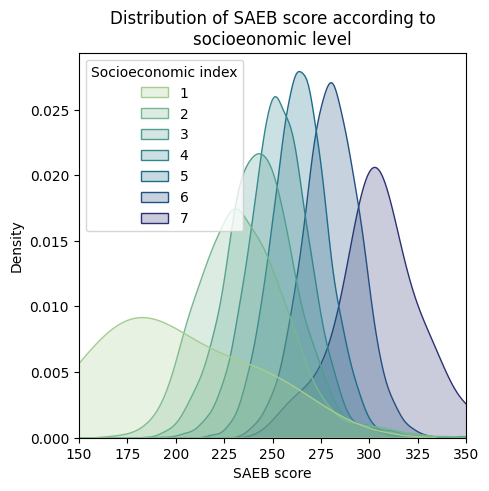

In [7]:
df["Socioeconomic index"] = df.NIVEL_SOCIO_ECONOMICO.apply(lambda x : {
    "i": 1, "ii" : 2, "iii" : 3, "iv" : 4, "v" : 5,
    "vi" : 6, "vii" : 7
}[x.split("-")[-1]])
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5 , 5))
sns.kdeplot(df, x="MEDIA", hue="Socioeconomic index", fill = True, palette = "crest", common_norm = False, ax = ax)
ax.set_xlabel("SAEB score")
sns.move_legend(ax, "upper left")
ax.set_xlim(150, 350)
ax.set_title("Distribution of SAEB score according to\nsocioeonomic level")
plt.show()

In [8]:
df = df.iloc[:, :-1]
df["MEDIA"] = (df["MEDIA"] < 250).astype(np.int64)

### Split data

In [9]:
target = "MEDIA"
num_features = df.select_dtypes("number").columns.tolist()
num_features = [col for col in num_features if not col in binary_features]
cat_features = [col for col in df.columns if not (col in binary_features or col in num_features)]
num_features.remove(target)
df_one_hot = pd.merge(
    df[num_features + binary_features + [target]],
    pd.get_dummies(df[cat_features]),
    left_index = True,
    right_index = True
)
df_one_hot

,PC_FORMACAO_DOCENTE_FINAL,NU_MATRICULADOS_CENSO_9EF,NU_PRESENTES_9EF,TAXA_PARTICIPACAO_9EF,TX_RESP_Q010,TX_RESP_Q011,TX_RESP_Q012,TX_RESP_Q013,TX_RESP_Q014,TX_RESP_Q015,...,TX_RESP_Q252_A,TX_RESP_Q252_B,TX_RESP_Q252_C,TX_RESP_Q252_D,TX_RESP_Q252_E,TX_RESP_Q253_A,TX_RESP_Q253_B,TX_RESP_Q253_C,TX_RESP_Q253_D,TX_RESP_Q253_E
0,48.9,14.0,14.0,1.000000,40.0,2.0,2.0,2.0,2.0,4.0,...,0,0,1,0,0,0,0,1,0,0
1,55.6,16.0,14.0,0.875000,40.0,1.0,1.0,1.0,2.0,20.0,...,0,0,0,1,0,0,0,0,1,0
2,45.5,12.0,10.0,0.833333,40.0,2.0,1.0,5.0,1.0,6.0,...,0,0,0,1,0,0,0,0,1,0
3,72.9,209.0,195.0,0.933014,40.0,2.0,1.0,2.0,1.0,2.0,...,0,0,0,1,0,0,0,0,0,1
4,36.5,12.0,10.0,0.833333,40.0,1.0,1.0,3.0,2.0,6.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23935,93.7,240.0,196.0,0.816667,40.0,2.0,6.0,10.0,10.0,10.0,...,0,0,0,0,1,0,0,0,0,1
23936,82.4,60.0,48.0,0.800000,60.0,5.0,0.0,2.0,20.0,20.0,...,0,0,0,1,0,0,0,0,1,0
23937,85.2,213.0,198.0,0.929577,44.0,7.0,10.0,8.0,7.0,2.0,...,0,0,0,1,0,0,0,0,1,0
23938,84.7,292.0,248.0,0.849315,59.0,6.0,8.0,4.0,3.0,8.0,...,0,0,0,1,0,0,0,0,0,1


In [10]:
Y = df_one_hot[target]
X = df_one_hot.drop(columns = [target])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

## Feature Analysis

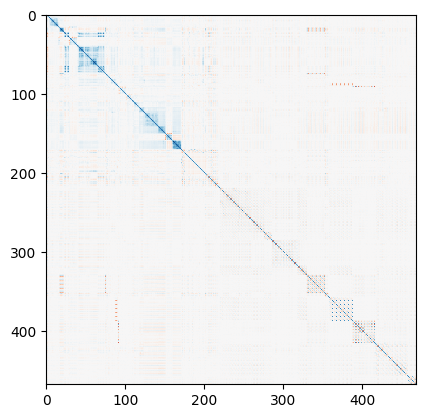

In [11]:
data_corr = X_train.corr()
plt.imshow(data_corr, cmap = "RdBu", vmin = -1, vmax = 1)
plt.show()

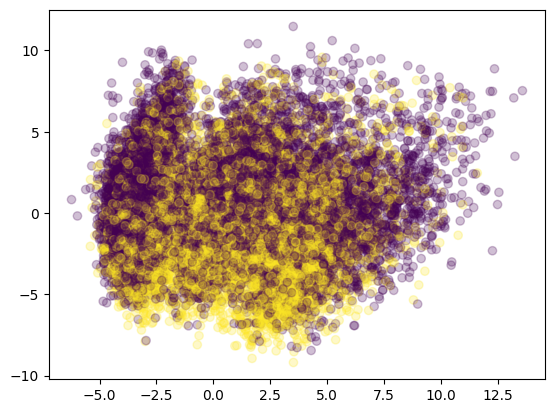

In [12]:
x_ = StandardScaler().fit_transform(X_train[num_features + binary_features])
x_2d = PCA().fit_transform(x_)
plt.scatter(x_2d[:, 0], x_2d[:, 1], c = Y_train, cmap = "viridis", alpha = 0.25)
plt.show()

In [13]:
# remove columns with correlation bigger than 0.7
corr_limit = 0.7
corr_pair = data_corr.abs().unstack()
corr_pair = list(zip(corr_pair.index.tolist(), corr_pair.tolist()))
corr_pair = [[t_[0][0], t_[0][1], t_[1]] for t_ in corr_pair]
corr_pair = [t_ for t_ in corr_pair if t_[0] != t_[1]]
corr_pair.sort(key = lambda x : -x[2])
corr_pair = corr_pair[::2]
corr_pair = [t_ for t_ in corr_pair if t_[2] > corr_limit]
correlated_columns_to_drop = set()

for col1, col2, _ in corr_pair:
  if col1 in correlated_columns_to_drop or col2 in correlated_columns_to_drop:
    continue
  correlated_columns_to_drop.add(col1)
correlated_columns_to_drop = list(correlated_columns_to_drop)
len(correlated_columns_to_drop), correlated_columns_to_drop

(62,
 ['TX_RESP_Q050_B',
  'TX_RESP_Q160_A',
  'TX_RESP_Q040',
  'TX_RESP_Q252_E',
  'TX_RESP_Q160_invalido',
  'TX_RESP_Q164_A',
  'ID_AREA_capital',
  'TX_RESP_Q106_B',
  'TX_RESP_Q068_A',
  'TX_RESP_Q069_A',
  'TX_RESP_Q150_C',
  'NU_MATRICULADOS_CENSO_9EF',
  'TX_RESP_Q159_A',
  'TX_RESP_Q109',
  'TX_RESP_Q161_A',
  'TX_RESP_Q199_D',
  'TX_RESP_Q052_C',
  'TX_RESP_Q129',
  'TX_RESP_Q054_B',
  'TX_RESP_Q153_invalido',
  'TX_RESP_Q036',
  'TX_RESP_Q162_A',
  'TX_RESP_Q047_B',
  'TX_RESP_Q096',
  'TX_RESP_Q112',
  'TX_RESP_Q035',
  'TX_RESP_Q154_invalido',
  'TX_RESP_Q075_A',
  'TX_RESP_Q150_invalido',
  'TX_RESP_Q073_A',
  'TX_RESP_Q241',
  'TX_RESP_Q053_B',
  'TX_RESP_Q242',
  'TX_RESP_Q205_D',
  'TX_RESP_Q051_C',
  'TX_RESP_Q163_A',
  'TX_RESP_Q079',
  'ID_LOCALIZACAO_rural',
  'TX_RESP_Q127_invalido',
  'TX_RESP_Q049_B',
  'TX_RESP_Q151_invalido',
  'TX_RESP_Q152_invalido',
  'TX_RESP_Q001_A',
  'TX_RESP_Q070_A',
  'TX_RESP_Q071_A',
  'TX_RESP_Q232',
  'TX_RESP_Q125_invalido',
  '

In [14]:
X_train = X_train.drop(columns = correlated_columns_to_drop)
X_test = X_test.drop(columns = correlated_columns_to_drop)

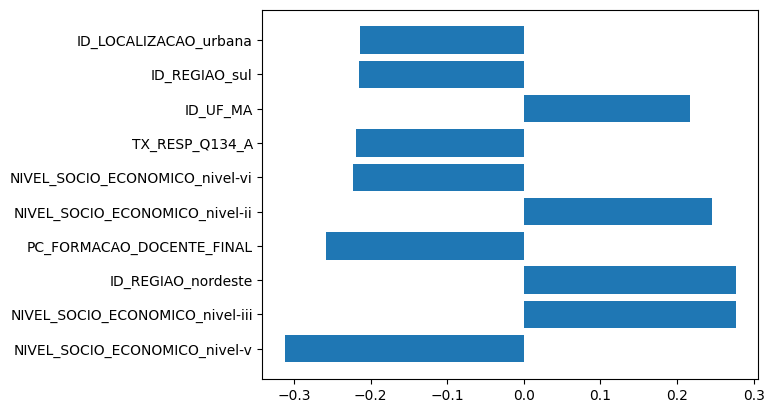

In [15]:
correlation_with_target = [(col, pearsonr(X_train[col], Y_train)[0]) for col in X_train.columns]
correlation_with_target.sort(key = lambda x : -abs(x[1]))
correlation_with_target = correlation_with_target[:10]
plt.barh(list(range(10)), [x[1] for x in correlation_with_target])
plt.yticks(list(range(10)), labels = [x[0] for x in correlation_with_target])
plt.show()

In [16]:
print(f"Fraction of positive samples: {Y_train.mean()}")

Fraction of positive samples: 0.3972953216374269


## Models training

### Simple models

KNN and Linear SVM

In [17]:
num_features_updated = [feat for feat in num_features if feat in X_train.columns]
binary_features_updated = [feat for feat in binary_features if feat in X_train.columns]
cat_features_updated = [feat for feat in X_train.columns if not (feat in num_features_updated or feat in binary_features_updated)]

In [18]:
pipeline = [(
    "preprocess", ColumnTransformer([
        ["scaling", StandardScaler(), num_features_updated],
    ], remainder = "passthrough",

    )
)]

In [27]:
KNeighborsClassifier,
params_space = {
    "knn" : {
     "classifier__n_neighbors":   [3, 5, 8, 10, 13, 15, 20]
    },
    "svm" : {
        "classifier__C" : [0.01, 0.1, 1, 10, 100],
    }
}
classifiers = {
    "knn" : KNeighborsClassifier,
    "svm" : LinearSVC
}
classifiers_fit = {}
for model in classifiers.keys():
  m = Pipeline(
      pipeline + [("classifier", classifiers[model]())]
  )
  grid = GridSearchCV(m, params_space[model], scoring = "recall", n_jobs = -1)
  grid.fit(X_train, Y_train)
  classifiers_fit[model] = grid

In [28]:
for name, model in classifiers_fit.items():
  Y_pred = model.predict(X_test)
  print(f"{name}:")
  print(f"\tAcc:{accuracy_score(Y_pred, Y_test)}")
  print(f"\tRecall:{recall_score(Y_pred, Y_test)}")
  print(f"\tPrec.:{precision_score(Y_pred, Y_test)}")

knn:
	Acc:0.6614452798663325
	Recall:0.5898842169408897
	Prec.:0.5052192066805845
svm:
	Acc:0.7598162071846283
	Recall:0.7247652582159625
	Prec.:0.644572025052192


### Complex Models

Logistic Regression and LightGBM

In [ ]:
params_space["lr"] = {
      "C" : [0.001, 0.01, 0.1, 1, 10, 100],
      "max_iter" : [1000]
}
params_space["lgbm"] = {
  'learning_rate': [0.001, 0.01, 0.1, 1],
  "num_leaves" : [5, 10, 20, 50],
  "max_depth" : [4, 6, 8, 10],
  "colsample_bytree" : [0.25, 0.5, 0.75, 1],
  "n_estimators" : [5, 10, 15, 20, 50],
  "verbose" : [-1],
}
classifiers["lr"] = LogisticRegression
classifiers["lgbm"] = LGBMClassifier
for model in ["lgbm"]:
  grid = GridSearchCV(classifiers[model](), params_space[model])
  grid.fit(x_train, y_train)
  classifiers_fit[model] = grid

In [ ]:
for name, model in classifiers_fit.items():
  print(name, model.score(x_test, y_test))

knn 0.7144945697577276
lr 0.7506265664160401
lgbm 0.7533416875522139
